In [1]:
import jax
import jax.numpy as jnp
from jax import random, vmap, jit

import numpy as np
import pymc as pm
import pymc.sampling_jax
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sgmcmcjax.samplers import build_sgld_sampler, build_sgldCV_sampler
import optax
from sgmcmcjax.optimizer import build_optax_optimizer

print(f"Running on PyMC v{pm.__version__}")

/Users/jeremiecoullon/Documents/research/jax/sgmcmc_samplers/venv/lib/python3.8/site-packages/aesara/link/jax/dispatch.py:86: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/Users/jeremiecoullon/Documents/research/jax/sgmcmc_samplers/venv/lib/python3.8/site-packages/pymc/sampling_jax.py:34: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


Running on PyMC v4.0.0b2



# Sample from a PyMC model using SGMCMCJax

todo:
- calculate ESS/sec and print out for sgld, sgld-cv, and NUTS
- try another model from the examples: https://docs.pymc.io/en/v3/nb_examples/index.html ? A lot of these don't use V4 (example PMF would be good to try out as it takes an hour for NUTS)

In [2]:
from pymc.sampling_jax import get_jaxified_graph

def build_pymc_loglik_logprior(model):

    original_data = []
    dummy_data_inputs = []
    for observed_RV in model.observed_RVs:
        data =  model.rvs_to_values[observed_RV]
        dummy_data_input = data.type()
        # TODO: You should revert these inplace changes after you're done
        model.rvs_to_values[observed_RV] = dummy_data_input
        original_data.append(data.data)
        dummy_data_inputs.append(dummy_data_input)

    # build loglik
    loglike_fn = get_jaxified_graph(
        inputs=model.value_vars + dummy_data_inputs,
        outputs=[model.datalogpt],
    )
    def pymc_loglikelihood(theta, x):
        return loglike_fn(*theta, x)[0]


    # build logprior
    logp_fn = get_jaxified_graph(
        outputs=[model.varlogpt],
    )

    def pymc_logprior(theta):
        return logp_fn(*theta)[0]

    return pymc_loglikelihood, pymc_logprior


## PyMC

In [4]:

# generate dataset
N, D = 10_000, 10
key = random.PRNGKey(0)
X_data = random.normal(key, shape=(N, D))


with pm.Model() as model:
    x = pm.Normal("x", 0, 10, shape=D)
    y = pm.Normal("y", x, observed=X_data)
    
    
model

## run PyMC sampler

In [5]:
%%time

with model:
    posterior = pm.sample(10_000, chains=1)

# adding this line adds a lot of time.
# is there a "block_until_ready()" missing somewhere?..
print(posterior.posterior.x.values[0,:][-1])

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
INFO:pymc:Sequential sampling (1 chains in 1 job)
NUTS: [x]
INFO:pymc:NUTS: [x]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 30 seconds.
INFO:pymc:Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 30 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc:Only one chain was sampled, this makes it impossible to run some convergence checks


[-0.00409768  0.00598126  0.00143343  0.01084321 -0.00564738  0.0039423
  0.01297556 -0.02975454 -0.01849593 -0.01484458]
CPU times: user 49.3 s, sys: 59.2 s, total: 1min 48s
Wall time: 2min 56s


### run using SGMCMCJax

In [6]:
pymc_loglikelihood, pymc_logprior = build_pymc_loglik_logprior(model)

In [7]:
# build sampler
batch_size = int(0.1*N)
dt = 1e-5

rvs = [rv.name for rv in model.value_vars]
init_position_dict = model.compute_initial_point()
init_position = [init_position_dict[rv] for rv in rvs]


# ========
my_sampler_pymc = build_sgld_sampler(dt, 
                                     pymc_loglikelihood, 
                                     pymc_logprior, 
                                     (X_data,), 
                                     batch_size)

# get MAP for SGLD-CV

# Adam
batch_size_adam = int(0.1 * N)
dt_adam = 1e-3
opt = optax.adam(learning_rate=dt_adam)
optimizer = build_optax_optimizer(opt, pymc_loglikelihood, pymc_logprior, (X_data,), batch_size_adam)
Niters = 10_000
opt_params, log_post_list = optimizer(key, Niters, init_position)

# define SGLD-CV
my_sampler_pymc_CV = build_sgldCV_sampler(dt, 
                                          pymc_loglikelihood, 
                                          pymc_logprior, 
                                          (X_data,), 
                                          batch_size, 
                                          opt_params)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
%%time

Nsamples = 10_000
# run SGLD
samples_pymc = my_sampler_pymc(key, Nsamples, init_position)
# run SGLD-CV
samples_pymc_CV = my_sampler_pymc_CV(key, Nsamples, init_position)

# result are in a PyTree
_ = samples_pymc[0].block_until_ready()
_ = samples_pymc_CV[0].block_until_ready()

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 4.32 s, sys: 78.5 ms, total: 4.4 s
Wall time: 4.43 s


### compare posterior samples

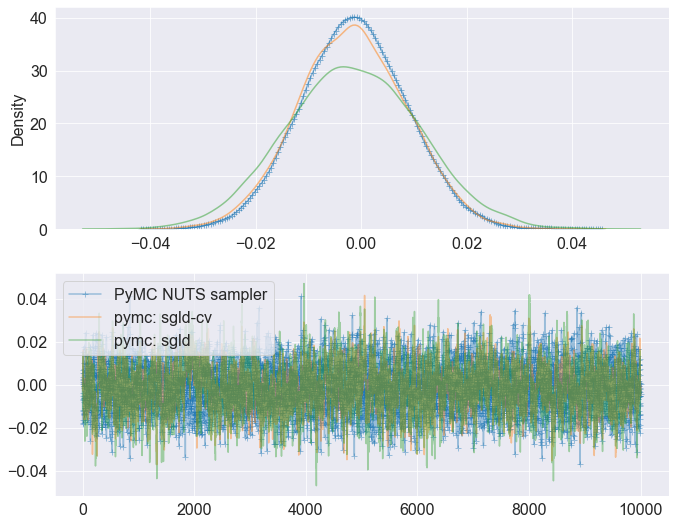

In [9]:
chain_num = 0
idx = 0

plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(2, figsize=(11, 9))
sns.kdeplot(posterior.posterior.x.values[chain_num, :, idx], 
            label="PyMC NUTS sampler", alpha=0.5, ax=ax[0], marker="+")
sns.kdeplot(samples_pymc_CV[0][:,idx], label="pymc: sgld-cv", alpha=0.5, ax=ax[0])
sns.kdeplot(samples_pymc[0][:,idx], label="pymc: sgld", alpha=0.5, ax=ax[0])

ax[1].plot(posterior.posterior.x.values[chain_num, :, idx], 
           label="PyMC NUTS sampler", alpha=0.4, marker="+")
ax[1].plot(samples_pymc_CV[0][:,idx], label="pymc: sgld-cv", alpha=0.4)
ax[1].plot(samples_pymc[0][:,idx], label="pymc: sgld", alpha=0.4)

plt.legend()